# Sentence-BERT (SBERT)

### Install Required Libraries

In [1]:
!pip install sentence-transformers scikit-learn matplotlib seaborn numpy scipy requests

### Load SBERT Model and Generate Embeddings

In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load pretrained SBERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Function to generate embeddings
def generate_sbert_embeddings(sentences):
    embeddings = sbert_model.encode(sentences, batch_size=32, convert_to_numpy=True)
    return embeddings

# Example usage
sample_sentences = ["I love this movie!", "This film was terrible."]
embeddings = generate_sbert_embeddings(sample_sentences)
print("Generated Embeddings Shape:", embeddings.shape)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generated Embeddings Shape: (2, 384)


## Classification Evaluation on MR Dataset

### Load MR Dataset

In [4]:
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Clone SentEval for datasets
!git clone https://github.com/facebookresearch/SentEval.git

# Download benchmark datasets from SentEval
%cd SentEval/data/downstream
!bash get_transfer_data.bash
%cd ../../../

# Load MR dataset
dataset_path = "./SentEval/data/downstream/MR"
with open(os.path.join(dataset_path, "rt-polarity.pos"), "r") as f_pos:
    positive_samples = [line.strip() for line in f_pos.readlines()]
with open(os.path.join(dataset_path, "rt-polarity.neg"), "r") as f_neg:
    negative_samples = [line.strip() for line in f_neg.readlines()]

sentences = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)


Cloning into 'SentEval'...
remote: Enumerating objects: 691, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 691 (delta 293), reused 277 (delta 277), pack-reused 296 (from 1)
Receiving objects: 100% (691/691), 33.23 MiB | 19.96 MiB/s, done.
Resolving deltas: 100% (452/452), done.
/content/SentEval/data/downstream
Cloning Moses github repository (for tokenization scripts)...
Cloning into 'mosesdecoder'...
remote: Enumerating objects: 148459, done.
remote: Counting objects: 100% (887/887), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 148459 (delta 565), reused 797 (delta 517), pack-reused 147572 (from 1)
Receiving objects: 100% (148459/148459), 129.99 MiB | 16.09 MiB/s, done.
Resolving deltas: 100% (114591/114591), done.
mkdir: cannot create directory ‘.’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload

### Generate Embeddings and Train Classifier

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1071
           1       0.76      0.76      0.76      1062

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133



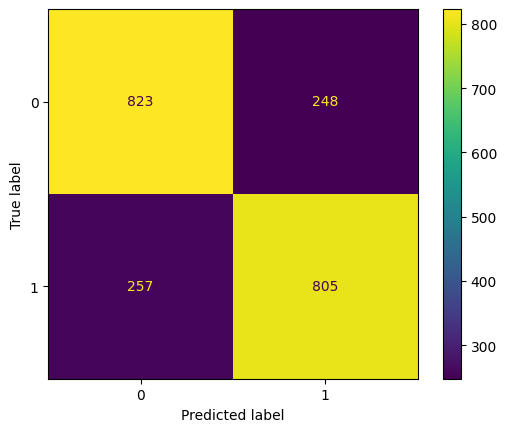

In [5]:
# Generate SBERT embeddings
X_train_embeddings = generate_sbert_embeddings(X_train)
X_test_embeddings = generate_sbert_embeddings(X_test)

# Train Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_embeddings)
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## STS Evaluation

In [6]:
import requests

def load_and_preprocess_sts_dataset(url, columns=(0, 1, 2), delimiter="\t", skip_header=True):
    response = requests.get(url)
    lines = response.text.splitlines()
    if skip_header:
        lines = lines[1:]

    word_pairs = []
    gold_scores = []
    for line in lines:
        parts = line.split(delimiter)
        if len(parts) >= max(columns):  # Check if the row has enough columns
            try:
                word1, word2, score = parts[columns[0]], parts[columns[1]], parts[columns[2]]
                word_pairs.append((word1, word2))
                gold_scores.append(float(score))
            except ValueError:
                print(f"Skipping invalid row: {parts}")  # Log invalid rows for debugging

    return word_pairs, gold_scores


In [7]:
# Dataset URLs
datasets = {
    "WS353-Sim": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/WS353-Sim.txt",
    "SimLex-999": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/SimLex999.txt",
    "SimVerb-3500": "https://jlu.myweb.cs.uwindsor.ca/8380/ws/SimVerb-3500.txt",
}

# Load WS353-Sim
ws353_word_pairs, ws353_gold_scores = load_and_preprocess_sts_dataset(
    datasets["WS353-Sim"], columns=(0, 1, 2), delimiter="\t", skip_header=False
)

# Load SimLex-999
simlex_word_pairs, simlex_gold_scores = load_and_preprocess_sts_dataset(
    datasets["SimLex-999"], columns=(0, 1, 2), delimiter="\t", skip_header=True
)

# Load SimVerb-3500
simverb_word_pairs, simverb_gold_scores = load_and_preprocess_sts_dataset(
    datasets["SimVerb-3500"], columns=(0, 1, 3), delimiter="\t", skip_header=True
)

In [8]:
def compute_similarity_sbert(word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        word1_emb = sbert_model.encode(word1, convert_to_numpy=True)
        word2_emb = sbert_model.encode(word2, convert_to_numpy=True)
        # Cosine similarity
        similarity = np.dot(word1_emb, word2_emb) / (np.linalg.norm(word1_emb) * np.linalg.norm(word2_emb))
        similarities.append(similarity)
    return similarities


In [9]:
# WS353-Sim
ws353_predicted_scores = compute_similarity_sbert(ws353_word_pairs)

# SimLex-999
simlex_predicted_scores = compute_similarity_sbert(simlex_word_pairs)

# SimVerb-3500
simverb_predicted_scores = compute_similarity_sbert(simverb_word_pairs)

In [10]:
from scipy.stats import spearmanr

def calculate_spearman_corr(gold_scores, predicted_scores):
    correlation, _ = spearmanr(gold_scores, predicted_scores)
    return correlation


In [11]:
# Spearman Correlation
ws353_corr = calculate_spearman_corr(ws353_gold_scores, ws353_predicted_scores)
simlex_corr = calculate_spearman_corr(simlex_gold_scores, simlex_predicted_scores)
simverb_corr = calculate_spearman_corr(simverb_gold_scores, simverb_predicted_scores)

# Display Results
print(f"Spearman Correlation on WS353-Sim: {ws353_corr}")
print(f"Spearman Correlation on SimLex-999: {simlex_corr}")
print(f"Spearman Correlation on SimVerb-3500: {simverb_corr}")


Spearman Correlation on WS353-Sim: 0.7670458218301094
Spearman Correlation on SimLex-999: 0.4469225066340064
Spearman Correlation on SimVerb-3500: 0.3319567496384283
